In [0]:
import os
import random
import numpy as np
import copy
from PIL import Image  

import PIL.Image as pil
from tqdm import tqdm
import torch
import torch.utils.data as data
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import skimage.transform
from collections import Counter
import time

import json


## Some helper functions are used from the original implementation
from utils import *
from layers import *
#from kitti_utils import *
#from layers import *


#import datasets
import networks
from IPython import embed


cuda = torch.cuda.is_available()
cuda

True

In [0]:
def pil_loader(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

In [0]:
class MainDataset(data.Dataset):
    
    def __init__(self,data_path,filenames,height,width,frame_idxs,num_scales,is_train=False,img_ext='.jpg'):
        super(MainDataset, self).__init__()
        
        self.data_path = data_path
        self.filenames = filenames
        self.height = height
        self.width = width
        self.num_scales = num_scales
        self.frame_idxs = frame_idxs
        self.is_train = is_train
        self.img_ext = img_ext
        
        # Interpolation Method during Scaling of the Images
        self.interp = Image.ANTIALIAS 
        
        self.loader = pil_loader
        self.to_tensor = transforms.ToTensor()
        
        # Randomly Change the Brightness, Contrast, Saturation and Hue of the Image
        # Tuple: (min,max)
        self.brig = (0.8,1.2)
        self.con = (0.8,1.2)
        self.sat = (0.8,1.2)
        self.hue = (-0.1, 0.1)
        # transforms.ColorJitter.get_params(brightness=(0.8,1.2),contrast=(0.8,1.2),saturation=(0.8,1.2),hue=(-0.1, 0.1))
        
        # Create a Dictionary (self.resize) of size of all the images after scaling
        # Scale = -1:(1242,375) - Native Resolution as loaded
        # Scale = 0:(192,640)  # Scale = 1:(96,320) # Scale = 2:(48,160) # Scale = 3:(24,80)
        # Interpolation while scaling = PIL.Image.LANCZOS
        self.resize = {}
        for i in range(self.num_scales):
            s = 2 ** i
            self.resize[i] = transforms.Resize((self.height // s, self.width // s),interpolation=self.interp)
            
        self.load_depth = self.check_depth()
        
        # Intrinsic Camera Matrix
        self.K = np.array([[0.58, 0, 0.5, 0],[0, 1.92, 0.5, 0],[0, 0, 1, 0],[0, 0, 0, 1]], dtype=np.float32)
        
        # Dimensions of the Original Image 
        self.full_res_shape = (1242, 375)
        
        self.side_map = {"2": 2, "3": 3, "l": 2, "r": 3}
    
    def __len__(self):
        return len(self.filenames)
    
    
    # Checks if the Loaded Filenames contains Velodyne Points a.k.a. Checks Depth if it exists
    def check_depth(self):
        
        line = self.filenames[0].split() # ['2011_09_26/2011_09_26_drive_0022_sync', '473', 'r']
        scene_name = line[0] # 2011_09_26/2011_09_26_drive_0022_sync
        frame_index = int(line[1]) # 473

        velo_filename = os.path.join(self.data_path,scene_name,"velodyne_points/data/{:010d}.bin".format(int(frame_index)))
        # /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/velodyne_points/data/0000000473.bin
        
        check_depth_boolean = os.path.isfile(velo_filename)
        
        return check_depth_boolean
    
    def get_image_path(self, folder, frame_index, side):
        
        f_str = "{:010d}{}".format(frame_index, self.img_ext)
        image_path = os.path.join(self.data_path, folder, "image_0{}/data".format(self.side_map[side]), f_str)
        # Ex: /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/image_03/data/0000000473.jpg
        
        return image_path
    
    def get_depth(self, folder, frame_index, side):
        
        # Data Path Ex: /home/ubuntu/monodepth2/kitti_data
        # Folder Ex: 2011_09_26/2011_09_26_drive_0022_sync
        
        calib_path = os.path.join(self.data_path, folder.split("/")[0])
        # Calib_Path Ex: /home/ubuntu/monodepth2/kitti_data/2011_09_26

        velo_filename = os.path.join(self.data_path,folder,"velodyne_points/data/{:010d}.bin".format(int(frame_index)))
        # Velo_Filename Ex: 
        # /home/ubuntu/monodepth2/kitti_data/2011_09_26/2011_09_26_drive_0022_sync/velodyne_points/data/0000000473.bin

        depth_gt = self.generate_depth_map(calib_path, velo_filename, self.side_map[side])
        # Shape of depth_gt: (375, 1242)
        depth_gt = skimage.transform.resize(depth_gt, self.full_res_shape[::-1], order=0, preserve_range=True, mode='constant')
        # Shape of depth_gt: (375, 1242)
        
        return depth_gt
    
    def load_velodyne_points(self,filename):

        points = np.fromfile(filename, dtype=np.float32).reshape(-1, 4)
        points[:, 3] = 1.0  # homogeneous
        return points
    
    def read_calib_file(self,path):

        float_chars = set("0123456789.e+- ")
        data = {}
        with open(path, 'r') as f:
            for line in f.readlines():
                key, value = line.split(':', 1)
                value = value.strip()
                data[key] = value
                if float_chars.issuperset(value):
                    # try to cast to float array
                    try:
                        data[key] = np.array(list(map(float, value.split(' '))))
                    except ValueError:
                        # casting error: data[key] already eq. value, so pass
                        pass

        return data
    
    def sub2ind(self,matrixSize, rowSub, colSub):

        m, n = matrixSize
        return rowSub * (n-1) + colSub - 1
    
    def generate_depth_map(self,calib_dir, velo_filename, cam=2, vel_depth=False):

        # load calibration files
        cam2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_cam_to_cam.txt'))
        velo2cam = self.read_calib_file(os.path.join(calib_dir, 'calib_velo_to_cam.txt'))
        velo2cam = np.hstack((velo2cam['R'].reshape(3, 3), velo2cam['T'][..., np.newaxis]))
        velo2cam = np.vstack((velo2cam, np.array([0, 0, 0, 1.0])))

        # get image shape
        im_shape = cam2cam["S_rect_02"][::-1].astype(np.int32)

        # compute projection matrix velodyne->image plane
        R_cam2rect = np.eye(4)
        R_cam2rect[:3, :3] = cam2cam['R_rect_00'].reshape(3, 3)
        P_rect = cam2cam['P_rect_0'+str(cam)].reshape(3, 4)
        P_velo2im = np.dot(np.dot(P_rect, R_cam2rect), velo2cam)

        # load velodyne points and remove all behind image plane (approximation)
        # each row of the velodyne data is forward, left, up, reflectance
        velo = self.load_velodyne_points(velo_filename)
        velo = velo[velo[:, 0] >= 0, :]

        # project the points to the camera
        velo_pts_im = np.dot(P_velo2im, velo.T).T
        velo_pts_im[:, :2] = velo_pts_im[:, :2] / velo_pts_im[:, 2][..., np.newaxis]

        if vel_depth:
            velo_pts_im[:, 2] = velo[:, 0]

        # check if in bounds
        # use minus 1 to get the exact same value as KITTI matlab code
        velo_pts_im[:, 0] = np.round(velo_pts_im[:, 0]) - 1
        velo_pts_im[:, 1] = np.round(velo_pts_im[:, 1]) - 1
        val_inds = (velo_pts_im[:, 0] >= 0) & (velo_pts_im[:, 1] >= 0)
        val_inds = val_inds & (velo_pts_im[:, 0] < im_shape[1]) & (velo_pts_im[:, 1] < im_shape[0])
        velo_pts_im = velo_pts_im[val_inds, :]

        # project to image
        depth = np.zeros((im_shape[:2]))
        depth[velo_pts_im[:, 1].astype(np.int), velo_pts_im[:, 0].astype(np.int)] = velo_pts_im[:, 2]

        # find the duplicate points and choose the closest depth
        inds = self.sub2ind(depth.shape, velo_pts_im[:, 1], velo_pts_im[:, 0])
        dupe_inds = [item for item, count in Counter(inds).items() if count > 1]
        for dd in dupe_inds:
            pts = np.where(inds == dd)[0]
            x_loc = int(velo_pts_im[pts[0], 0])
            y_loc = int(velo_pts_im[pts[0], 1])
            depth[y_loc, x_loc] = velo_pts_im[pts, 2].min()
        depth[depth < 0] = 0

        return depth
    
    def __getitem__(self,index):
        
        # The dictionary to be returned as a single training item
        inputs = {}
        
        do_color_aug = self.is_train and random.random() > 0.5
        do_flip = self.is_train and random.random() > 0.5
        
        line = self.filenames[index].split() # Ex: ['2011_09_26/2011_09_26_drive_0022_sync', '473', 'r']
        folder = line[0] # Ex: 2011_09_26/2011_09_26_drive_0022_sync
        
        if len(line) == 3:
            frame_index = int(line[1])
            side = line[2]
        else:
            frame_index = 0
            side = None
        
        
        # Append the images for each frame in the dictionary
        # Flip if do_flip is True
        for i in self.frame_idxs:
            
            if i != "s": # For Non Stereo
                
                color = self.loader(self.get_image_path(folder, frame_index + i, side))
                if do_flip == True:
                    color = color.transpose(pil.FLIP_LEFT_RIGHT)
                
                inputs[("color", i, -1)] = color
            
            else: #For Stereo
                
                other_side = {"r": "l", "l": "r"}[side]
                color = self.loader(self.get_image_path(folder, frame_index, other_side))
                if do_flip == True:
                    color = color.transpose(pil.FLIP_LEFT_RIGHT)
                    
                inputs[("color", i, -1)] = color
                
        
        # Construct the intrinsics for each scale and Append in the dictionary
        for scale in range(self.num_scales):
            
            K_scale = self.K.copy()
            K_scale[0,:] = K_scale[0,:] * (self.width // (2 ** scale))
            K_scale[1,:] = K_scale[1,:] * (self.height // (2 ** scale))
            
            # Compute the (Moore-Penrose) pseudo-inverse of a matrix.
            inverse_K_scale = np.linalg.pinv(K_scale)
            
            # Append K and its inverse for the particular 'scale'
            inputs[("K", scale)] = torch.from_numpy(K_scale)
            inputs[("inv_K", scale)] = torch.from_numpy(inverse_K_scale)
            
        # If Color Augmentation is True
        # Define color_aug to transform the image by changing its brightness, contrast, saturation and hue
        if do_color_aug == True:
            color_aug = transforms.ColorJitter.get_params(
                self.brig, self.con, self.sat, self.hue)
        else:
            color_aug = (lambda x: x)    
        
        
        # Till now, inputs contains images for all frames for only scale = -1
        # Append "color" images (and preprocessed to tensors) for all frames for other scales = 0,1,2,3 
        # Do similar and append for "color_aug" images do_color_aug is True
        # --->
        
        for k in list(inputs):
            frame = inputs[k]
            if "color" in k:
                n, im, i = k
                for i in range(self.num_scales):
                    inputs[(n, im, i)] = self.resize[i](inputs[(n, im, i - 1)])
            
        for k in list(inputs):
            f = inputs[k]
            if "color" in k:
                n, im, i = k
                inputs[(n, im, i)] = self.to_tensor(f)
                inputs[(n + "_aug", im, i)] = self.to_tensor(color_aug(f))
                
        # <---
        
        # Delete the scale of -1 as it indicates the default image resolution not required for training purposes
        for i in self.frame_idxs:
            del inputs[("color", i, -1)]
            del inputs[("color_aug", i, -1)]
                
        # Load Depth for the Images and Append to the dictionary of inputs
        if self.load_depth:
            depth_gt = self.get_depth(folder, frame_index, side)
            # Shape of depth_gt: (375, 1242)
            inputs["depth_gt"] = np.expand_dims(depth_gt, 0)
            inputs["depth_gt"] = torch.from_numpy(inputs["depth_gt"].astype(np.float32))
        
        # For Stereo
        if "s" in self.frame_idxs:
            stereo_T = np.eye(4, dtype=np.float32)
            baseline_sign =  -1 if do_flip else 1
            side_sign = -1 if side == "l" else 1
            stereo_T[0, 3] = side_sign * baseline_sign * 0.1

            inputs["stereo_T"] = torch.from_numpy(stereo_T)

        
        return inputs
        
        

In [0]:
## Load the data according to files listed in eigen_full split 

dataset =  MainDataset #datasets.KITTIRAWDataset
data_path = "/home/ubuntu/monodepth2/kitti_data"
fpath_train = "/home/ubuntu/monodepth2/splits/eigen_full/train_files.txt"
f_train = open(fpath_train)
train_filenames = f_train.readlines()
fpath_val = "/home/ubuntu/monodepth2/splits/eigen_full/val_files.txt"
f_val = open(fpath_val)
val_filenames = f_val.readlines()

In [0]:
## Size to rescale all input images to
height = 192
width = 640

## Scales of the output image from each layer of the decoder
## output scale = input scale/2**(n) for n in scales
scales = np.arange(4)

img_ext = '.jpg'
device = torch.device("cuda" if cuda else "cpu")

## List of frames that the dataloader must return 
## 0 - present frame
## 's' - stereo couple frame
frame_ids = [0,'s']

num_layers = 18
weights_init = 'pretrained'
weights_pretrained = True

num_scales = len(scales)
num_input_frames = len(frame_ids)

learning_rate = 0.0001

In [0]:
batch_size = 4
num_workers = 8

train_dataset = dataset(data_path, train_filenames, height, width,frame_ids,num_scales,is_train=True, img_ext=img_ext)
train_loader = DataLoader(train_dataset, batch_size, True,num_workers=num_workers, pin_memory=True, drop_last=True)

val_dataset = dataset(data_path, val_filenames, height, width,frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(val_dataset, batch_size, False,num_workers=num_workers, pin_memory=True, drop_last=True)

In [0]:
import torch
import torch.nn as nn

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.leakyreluA(self.convA( torch.cat([up_x, concat_with], dim=1) ) ) )  )

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        self.up1 = UpSample(skip_input=512//2+512, output_features=256)
        self.up2 = UpSample(skip_input=256//2 + 256, output_features=128)
        self.up3 = UpSample(skip_input=128//2 + 128, output_features=64)
        self.up4 = UpSample(skip_input=128, output_features=64)

        self.conv3 = nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[0], features[1], features[2], features[3], features[4]
        x_d1 = self.up1(x_block4, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        return nn.functional.sigmoid(self.conv3(x_d4))
#         return self.conv3(x_d4)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        from torchvision import models
        self.features = models.resnet18(pretrained=True)

    def forward(self, x):
        features= []
        features.append(self.features.relu(self.features.bn1(self.features.conv1(x))))
        features.append(self.features.layer1(features[-1]))
        features.append(self.features.layer2(features[-1]))
        features.append(self.features.layer3(features[-1]))
        features.append(self.features.layer4(features[-1]))
        return features

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [0]:
model = Model()
device = torch.device("cuda" if cuda else "cpu")
model.load_state_dict(torch.load('ManashOutputStereo/Epoch 1/model_epoch_1_MANASH.pt'))
model.to(device)
l1_criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [0]:

depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]


In [0]:
backproject_depth = {}
project_3d = {}
for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)

    backproject_depth[scale] = BackprojectDepth(batch_size, h, w)
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(batch_size, h, w)
    project_3d[scale].to(device)

#print("There are {:d} training items and {:d} validation items\n".format(len(train_dataset), len(val_dataset)))

In [0]:

def generate_images_pred(inputs, outputs):
        
   
        source_scale = 0
        output = {}

        disp = outputs
        output["disp"] = outputs

        disp = F.interpolate(disp, [height, width], mode="bilinear",align_corners=False)
        
        depth = 1 / (0.01 + 9.99*disp)
 
        output['depth'] = depth

        T = inputs["stereo_T"]

        cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)])
        pix_coords = project_3d[source_scale](cam_points, inputs[("K", source_scale)], T)

        output['image'] = F.grid_sample(inputs[("color", 's', source_scale)],pix_coords,padding_mode="border",align_corners=False)

        return  output


In [0]:
  
import torch
from math import exp
import torch.nn.functional as F

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window

def ssim_new(img1, img2, val_range, window_size=5, window=None, size_average=True, full=False):
    L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs

    return ret

In [0]:

def compute_reprojection_loss(pred, target):

        l1_loss = l1_criterion(pred, target)
        
        ssim_loss = torch.clamp((1 - ssim_new(pred, target,1)) * 0.5, 0, 1) 

        reprojection_loss = ssim_loss + 0.1* l1_loss

        return reprojection_loss


In [0]:
def compute_losses(inputs, outputs):

            losses = {}
            total_loss = 0
        
            loss = 0
            reprojection_losses = []

            source_scale = 0
            scale = 0

            disp = outputs['disp']
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            pred = outputs['image']

            loss = loss + compute_reprojection_loss(pred, target)

            total_loss = total_loss + loss
            losses["loss/{}".format(scale)] = loss

            losses["loss"] = total_loss
            return losses

In [0]:

def compute_depth_losses(inputs, outputs, losses):


        depth_pred = outputs["depth"]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), min=1e-3, max=80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        gt = depth_gt[mask]
        pred = depth_pred[mask]
        pred = pred*(torch.median(gt) / torch.median(pred))

        pred = torch.clamp(pred, min=1e-3, max=80)
        thresh = torch.max((gt / pred), (pred / gt))
        a1 = (thresh < 1.25     ).float().mean()
        a2 = (thresh < 1.25 ** 2).float().mean()
        a3 = (thresh < 1.25 ** 3).float().mean()

        rmse = torch.sqrt(((gt - pred)**2).mean())
        rmse_log = torch.sqrt(((torch.log(gt) - torch.log(pred))**2).mean())
        abs_rel = torch.mean(torch.abs(gt - pred) / gt)
        sq_rel = torch.mean(((gt - pred)**2 )/ gt)
        
        return np.array([abs_rel.item(),sq_rel.item(),rmse.item(),rmse_log.item(),a1.item(),a2.item(),a3.item()])


In [0]:
def train(model,train_loader,val_loader,num_epochs):
             
        model.train()
        
        for epoch in range(num_epochs):
            total_loss = 0 
            outer = tqdm(total=(len(train_loader)), desc='Training Epoch', position=0)

            for batch_idx, inputs in enumerate(train_loader):
                
                    outer.update(1)
                    
                    optimizer.zero_grad()

                    for key, ipt in inputs.items():
                        inputs[key] = ipt.to(device)
    
                    outputsl = model(inputs["color_aug", 0, 0])
                    outputs = generate_images_pred(inputs, outputsl)

                    losses = compute_losses(inputs, outputs)
                    total_loss = total_loss + losses['loss'].item()

                    losses["loss"].backward()
                    optimizer.step()
                    
                    del inputs, outputs,outputsl
                    if batch_idx%100==0 and batch_idx>0:
                        print('Batch No: ',batch_idx)
                        print('Loss: ',losses["loss"].cpu().data)
                    del losses     
  
            total_loss = total_loss/len(train_loader)
            print('Train Loss at Epoch_{}:'.format(epoch+1),total_loss)
            validation(model,val_loader)

In [0]:
def validation(model,val_loader):
    
    with torch.no_grad():
        
        model.eval()
        total_loss = 0
        metrics = np.zeros((7))
        outer = tqdm(total=(len(val_loader)), desc='Validation Epoch', position=0)

                
        for batch_idx, inputs in enumerate(val_loader):

            outer.update(1)

            for key, ipt in inputs.items():
                inputs[key] = ipt.to(device)

            outputsl = model(inputs["color_aug", 0, 0])
            
            outputs = generate_images_pred(inputs, outputsl)
            losses = compute_losses(inputs, outputs)
            total_loss = total_loss + losses['loss'].item()
         
            metrics = metrics + compute_depth_losses(inputs, outputs, losses)
            del inputs, outputs, losses, outputsl
         
        total_loss = total_loss/len(val_loader)
        print('Total Loss (Validation): ',total_loss)
        print('Error Metrics: ',metrics/len(val_loader))      

In [0]:
num_epochs = 1
train(model,train_loader,val_loader,num_epochs)

Training Epoch:   1%|          | 102/11300 [00:26<49:20,  3.78it/s] 

Batch No:  100
Loss:  tensor(0.2493)


Training Epoch:   2%|▏         | 202/11300 [00:50<57:59,  3.19it/s]  

Batch No:  200
Loss:  tensor(0.1890)


Training Epoch:   3%|▎         | 302/11300 [01:15<1:08:39,  2.67it/s]

Batch No:  300
Loss:  tensor(0.1761)


Training Epoch:   4%|▎         | 403/11300 [01:39<36:31,  4.97it/s]  

Batch No:  400
Loss:  tensor(0.2269)


Training Epoch:   4%|▍         | 502/11300 [02:03<45:51,  3.92it/s]  

Batch No:  500
Loss:  tensor(0.1810)


Training Epoch:   5%|▌         | 602/11300 [02:27<43:49,  4.07it/s]  

Batch No:  600
Loss:  tensor(0.2186)


Training Epoch:   6%|▌         | 702/11300 [02:52<42:28,  4.16it/s]  

Batch No:  700
Loss:  tensor(0.2162)


Training Epoch:   7%|▋         | 802/11300 [03:17<43:22,  4.03it/s]  

Batch No:  800
Loss:  tensor(0.2525)


Training Epoch:   8%|▊         | 902/11300 [03:42<44:29,  3.90it/s]  

Batch No:  900
Loss:  tensor(0.2159)


Training Epoch:   9%|▉         | 1001/11300 [04:06<36:24,  4.72it/s] 

Batch No:  1000
Loss:  tensor(0.1313)


Training Epoch:  10%|▉         | 1102/11300 [04:32<45:57,  3.70it/s]  

Batch No:  1100
Loss:  tensor(0.1834)


Training Epoch:  11%|█         | 1202/11300 [04:55<47:14,  3.56it/s]  

Batch No:  1200
Loss:  tensor(0.1841)


Training Epoch:  12%|█▏        | 1302/11300 [05:21<45:13,  3.69it/s]  

Batch No:  1300
Loss:  tensor(0.1847)


Training Epoch:  12%|█▏        | 1402/11300 [05:46<41:45,  3.95it/s]  

Batch No:  1400
Loss:  tensor(0.1719)


Training Epoch:  13%|█▎        | 1502/11300 [06:10<41:13,  3.96it/s]  

Batch No:  1500
Loss:  tensor(0.1832)


Training Epoch:  14%|█▍        | 1602/11300 [06:35<52:59,  3.05it/s]  

Batch No:  1600
Loss:  tensor(0.1797)


Training Epoch:  15%|█▌        | 1702/11300 [07:00<42:46,  3.74it/s]  

Batch No:  1700
Loss:  tensor(0.2320)


Training Epoch:  16%|█▌        | 1802/11300 [07:24<40:33,  3.90it/s]  

Batch No:  1800
Loss:  tensor(0.1834)


Training Epoch:  17%|█▋        | 1901/11300 [07:49<35:52,  4.37it/s]  

Batch No:  1900
Loss:  tensor(0.1640)


Training Epoch:  18%|█▊        | 2002/11300 [08:13<57:41,  2.69it/s]  

Batch No:  2000
Loss:  tensor(0.1747)


Training Epoch:  19%|█▊        | 2102/11300 [08:38<42:08,  3.64it/s]  

Batch No:  2100
Loss:  tensor(0.1923)


Training Epoch:  19%|█▉        | 2202/11300 [09:02<39:45,  3.81it/s]  

Batch No:  2200
Loss:  tensor(0.1721)


Training Epoch:  20%|██        | 2302/11300 [09:27<38:05,  3.94it/s]  

Batch No:  2300
Loss:  tensor(0.1863)


Training Epoch:  21%|██▏       | 2402/11300 [09:53<39:33,  3.75it/s]  

Batch No:  2400
Loss:  tensor(0.1940)


Training Epoch:  22%|██▏       | 2502/11300 [10:17<38:11,  3.84it/s]  

Batch No:  2500
Loss:  tensor(0.2074)


Training Epoch:  23%|██▎       | 2602/11300 [10:42<37:11,  3.90it/s]  

Batch No:  2600
Loss:  tensor(0.1834)


Training Epoch:  24%|██▍       | 2702/11300 [11:04<37:14,  3.85it/s]

Batch No:  2700
Loss:  tensor(0.2172)


Training Epoch:  25%|██▍       | 2802/11300 [11:29<37:18,  3.80it/s]  

Batch No:  2800
Loss:  tensor(0.1335)


Training Epoch:  26%|██▌       | 2902/11300 [11:52<36:10,  3.87it/s]

Batch No:  2900
Loss:  tensor(0.1369)


Training Epoch:  27%|██▋       | 3002/11300 [12:16<35:52,  3.86it/s]

Batch No:  3000
Loss:  tensor(0.1610)


Training Epoch:  27%|██▋       | 3102/11300 [12:40<36:05,  3.79it/s]

Batch No:  3100
Loss:  tensor(0.1606)


Training Epoch:  28%|██▊       | 3202/11300 [13:04<34:56,  3.86it/s]

Batch No:  3200
Loss:  tensor(0.1647)


Training Epoch:  29%|██▉       | 3302/11300 [13:28<35:42,  3.73it/s]

Batch No:  3300
Loss:  tensor(0.2057)


Training Epoch:  30%|███       | 3402/11300 [13:52<34:11,  3.85it/s]

Batch No:  3400
Loss:  tensor(0.1908)


Training Epoch:  31%|███       | 3502/11300 [14:16<35:35,  3.65it/s]

Batch No:  3500
Loss:  tensor(0.2035)


Training Epoch:  32%|███▏      | 3602/11300 [14:39<32:25,  3.96it/s]

Batch No:  3600
Loss:  tensor(0.1723)


Training Epoch:  33%|███▎      | 3702/11300 [15:03<38:02,  3.33it/s]

Batch No:  3700
Loss:  tensor(0.1718)


Training Epoch:  34%|███▎      | 3802/11300 [15:28<33:30,  3.73it/s]  

Batch No:  3800
Loss:  tensor(0.1569)


Training Epoch:  35%|███▍      | 3902/11300 [15:53<32:31,  3.79it/s]  

Batch No:  3900
Loss:  tensor(0.1970)


Training Epoch:  35%|███▌      | 4002/11300 [16:16<31:28,  3.86it/s]

Batch No:  4000
Loss:  tensor(0.2095)


Training Epoch:  36%|███▋      | 4102/11300 [16:40<32:41,  3.67it/s]

Batch No:  4100
Loss:  tensor(0.2246)


Training Epoch:  37%|███▋      | 4202/11300 [17:05<30:17,  3.91it/s]

Batch No:  4200
Loss:  tensor(0.1335)


Training Epoch:  38%|███▊      | 4302/11300 [17:29<29:56,  3.90it/s]

Batch No:  4300
Loss:  tensor(0.1757)


Training Epoch:  39%|███▉      | 4402/11300 [17:53<30:07,  3.82it/s]

Batch No:  4400
Loss:  tensor(0.2326)


Training Epoch:  40%|███▉      | 4502/11300 [18:18<28:43,  3.94it/s]

Batch No:  4500
Loss:  tensor(0.1095)


Training Epoch:  41%|████      | 4602/11300 [18:41<29:47,  3.75it/s]

Batch No:  4600
Loss:  tensor(0.1463)


Training Epoch:  42%|████▏     | 4702/11300 [19:05<28:19,  3.88it/s]

Batch No:  4700
Loss:  tensor(0.1516)


Training Epoch:  42%|████▏     | 4802/11300 [19:29<27:46,  3.90it/s]

Batch No:  4800
Loss:  tensor(0.1911)


Training Epoch:  43%|████▎     | 4902/11300 [19:53<30:35,  3.49it/s]

Batch No:  4900
Loss:  tensor(0.1895)


Training Epoch:  44%|████▍     | 5002/11300 [20:17<27:59,  3.75it/s]

Batch No:  5000
Loss:  tensor(0.1981)


Training Epoch:  45%|████▌     | 5102/11300 [20:41<27:10,  3.80it/s]

Batch No:  5100
Loss:  tensor(0.1958)


Training Epoch:  46%|████▌     | 5202/11300 [21:05<25:46,  3.94it/s]

Batch No:  5200
Loss:  tensor(0.1958)


Training Epoch:  47%|████▋     | 5302/11300 [21:30<26:36,  3.76it/s]

Batch No:  5300
Loss:  tensor(0.1677)


Training Epoch:  48%|████▊     | 5402/11300 [21:54<25:36,  3.84it/s]

Batch No:  5400
Loss:  tensor(0.1947)


Training Epoch:  49%|████▊     | 5502/11300 [22:18<25:32,  3.78it/s]

Batch No:  5500
Loss:  tensor(0.2017)


Training Epoch:  50%|████▉     | 5602/11300 [22:42<24:34,  3.86it/s]

Batch No:  5600
Loss:  tensor(0.1825)


Training Epoch:  50%|█████     | 5702/11300 [23:06<24:24,  3.82it/s]

Batch No:  5700
Loss:  tensor(0.2173)


Training Epoch:  51%|█████▏    | 5802/11300 [23:30<24:04,  3.81it/s]

Batch No:  5800
Loss:  tensor(0.1709)


Training Epoch:  52%|█████▏    | 5902/11300 [23:54<23:55,  3.76it/s]

Batch No:  5900
Loss:  tensor(0.1630)


Training Epoch:  53%|█████▎    | 6002/11300 [24:17<25:05,  3.52it/s]

Batch No:  6000
Loss:  tensor(0.1758)


Training Epoch:  54%|█████▍    | 6102/11300 [24:42<22:58,  3.77it/s]

Batch No:  6100
Loss:  tensor(0.1751)


Training Epoch:  55%|█████▍    | 6202/11300 [25:06<25:24,  3.34it/s]

Batch No:  6200
Loss:  tensor(0.1691)


Training Epoch:  56%|█████▌    | 6302/11300 [25:30<23:14,  3.58it/s]

Batch No:  6300
Loss:  tensor(0.1822)


Training Epoch:  57%|█████▋    | 6401/11300 [25:55<18:25,  4.43it/s]

Batch No:  6400
Loss:  tensor(0.1637)


Training Epoch:  58%|█████▊    | 6502/11300 [26:20<22:09,  3.61it/s]

Batch No:  6500
Loss:  tensor(0.2114)


Training Epoch:  58%|█████▊    | 6602/11300 [26:43<20:19,  3.85it/s]

Batch No:  6600
Loss:  tensor(0.2082)


Training Epoch:  59%|█████▉    | 6702/11300 [27:06<20:27,  3.75it/s]

Batch No:  6700
Loss:  tensor(0.1479)


Training Epoch:  60%|██████    | 6802/11300 [27:30<21:16,  3.52it/s]

Batch No:  6800
Loss:  tensor(0.1338)


Training Epoch:  61%|██████    | 6902/11300 [27:54<19:25,  3.78it/s]

Batch No:  6900
Loss:  tensor(0.1889)


Training Epoch:  62%|██████▏   | 7002/11300 [28:18<19:04,  3.75it/s]

Batch No:  7000
Loss:  tensor(0.1665)


Training Epoch:  63%|██████▎   | 7102/11300 [28:42<23:36,  2.96it/s]

Batch No:  7100
Loss:  tensor(0.1887)


Training Epoch:  64%|██████▎   | 7202/11300 [29:06<16:30,  4.14it/s]

Batch No:  7200
Loss:  tensor(0.4039)


Training Epoch:  65%|██████▍   | 7302/11300 [29:30<19:17,  3.45it/s]

Batch No:  7300
Loss:  tensor(0.3346)


Training Epoch:  66%|██████▌   | 7402/11300 [29:54<19:28,  3.34it/s]

Batch No:  7400
Loss:  tensor(0.3560)


Training Epoch:  66%|██████▋   | 7502/11300 [30:19<16:48,  3.77it/s]

Batch No:  7500
Loss:  tensor(0.3632)


Training Epoch:  67%|██████▋   | 7602/11300 [30:44<19:30,  3.16it/s]

Batch No:  7600
Loss:  tensor(0.4051)


Training Epoch:  68%|██████▊   | 7702/11300 [31:09<14:49,  4.04it/s]

Batch No:  7700
Loss:  tensor(0.4000)


Training Epoch:  69%|██████▉   | 7802/11300 [31:32<13:33,  4.30it/s]

Batch No:  7800
Loss:  tensor(0.3734)


Training Epoch:  70%|██████▉   | 7902/11300 [31:56<14:56,  3.79it/s]

Batch No:  7900
Loss:  tensor(0.3820)


Training Epoch:  71%|███████   | 8002/11300 [32:19<12:22,  4.44it/s]

Batch No:  8000
Loss:  tensor(0.3450)


Training Epoch:  72%|███████▏  | 8101/11300 [32:43<13:54,  3.83it/s]

Batch No:  8100
Loss:  tensor(0.4313)


Training Epoch:  73%|███████▎  | 8202/11300 [33:08<11:52,  4.35it/s]

Batch No:  8200
Loss:  tensor(0.3781)


Training Epoch:  73%|███████▎  | 8302/11300 [33:32<11:34,  4.32it/s]

Batch No:  8300
Loss:  tensor(0.3836)


Training Epoch:  74%|███████▍  | 8401/11300 [33:55<10:19,  4.68it/s]

Batch No:  8400
Loss:  tensor(0.3638)


Training Epoch:  75%|███████▌  | 8502/11300 [34:19<10:47,  4.32it/s]

Batch No:  8500
Loss:  tensor(0.3437)


Training Epoch:  76%|███████▌  | 8601/11300 [34:42<12:53,  3.49it/s]

Batch No:  8600
Loss:  tensor(0.3665)


Training Epoch:  77%|███████▋  | 8702/11300 [35:06<11:40,  3.71it/s]

Batch No:  8700
Loss:  tensor(0.3483)


Training Epoch:  78%|███████▊  | 8802/11300 [35:28<10:29,  3.97it/s]

Batch No:  8800
Loss:  tensor(0.3538)


Training Epoch:  79%|███████▉  | 8902/11300 [35:52<09:15,  4.32it/s]

Batch No:  8900
Loss:  tensor(0.3410)


Training Epoch:  80%|███████▉  | 9002/11300 [36:16<13:04,  2.93it/s]

Batch No:  9000
Loss:  tensor(0.3705)


Training Epoch:  81%|████████  | 9102/11300 [36:41<09:43,  3.77it/s]

Batch No:  9100
Loss:  tensor(0.3798)


Training Epoch:  81%|████████▏ | 9202/11300 [37:04<08:25,  4.15it/s]

Batch No:  9200
Loss:  tensor(0.3689)


Training Epoch:  82%|████████▏ | 9302/11300 [37:28<08:22,  3.98it/s]

Batch No:  9300
Loss:  tensor(0.3622)


Training Epoch:  83%|████████▎ | 9402/11300 [37:53<10:51,  2.91it/s]

Batch No:  9400
Loss:  tensor(0.3682)


Training Epoch:  84%|████████▍ | 9503/11300 [38:16<05:42,  5.24it/s]

Batch No:  9500
Loss:  tensor(0.3366)


Training Epoch:  85%|████████▍ | 9602/11300 [38:41<06:26,  4.39it/s]

Batch No:  9600
Loss:  tensor(0.4190)


Training Epoch:  86%|████████▌ | 9702/11300 [39:05<07:58,  3.34it/s]

Batch No:  9700
Loss:  tensor(0.3665)


Training Epoch:  87%|████████▋ | 9802/11300 [39:29<07:42,  3.24it/s]

Batch No:  9800
Loss:  tensor(0.4115)


Training Epoch:  88%|████████▊ | 9901/11300 [39:53<05:21,  4.35it/s]

Batch No:  9900
Loss:  tensor(0.3520)


Training Epoch:  89%|████████▊ | 10002/11300 [40:18<05:12,  4.16it/s]

Batch No:  10000
Loss:  tensor(0.3776)


Training Epoch:  89%|████████▉ | 10101/11300 [40:41<04:10,  4.78it/s]

Batch No:  10100
Loss:  tensor(0.3797)


Training Epoch:  90%|█████████ | 10203/11300 [41:06<03:27,  5.30it/s]

Batch No:  10200
Loss:  tensor(0.3642)


Training Epoch:  91%|█████████ | 10302/11300 [41:29<04:05,  4.06it/s]

Batch No:  10300
Loss:  tensor(0.3727)


Training Epoch:  92%|█████████▏| 10403/11300 [41:54<03:01,  4.94it/s]

Batch No:  10400
Loss:  tensor(0.4322)


Training Epoch:  93%|█████████▎| 10501/11300 [42:17<02:38,  5.04it/s]

Batch No:  10500
Loss:  tensor(0.3915)


Training Epoch:  94%|█████████▍| 10602/11300 [42:42<03:33,  3.27it/s]

Batch No:  10600
Loss:  tensor(0.3394)


Training Epoch:  95%|█████████▍| 10702/11300 [43:07<02:15,  4.42it/s]

Batch No:  10700
Loss:  tensor(0.3510)


Training Epoch:  96%|█████████▌| 10802/11300 [43:32<02:07,  3.89it/s]

Batch No:  10800
Loss:  tensor(0.3910)


Training Epoch:  96%|█████████▋| 10903/11300 [43:56<01:16,  5.18it/s]

Batch No:  10900
Loss:  tensor(0.3611)


Training Epoch:  97%|█████████▋| 11002/11300 [44:21<01:22,  3.59it/s]

Batch No:  11000
Loss:  tensor(0.3579)


Training Epoch:  98%|█████████▊| 11102/11300 [44:45<00:46,  4.28it/s]

Batch No:  11100
Loss:  tensor(0.3922)


Training Epoch:  99%|█████████▉| 11202/11300 [45:09<00:26,  3.69it/s]

Batch No:  11200
Loss:  tensor(0.3909)


Validation Epoch:   0%|          | 0/444 [00:00<?, ?it/s],  5.45it/s]

Train Loss at Epoch_1: 0.2519862317260915


Validation Epoch: 100%|█████████▉| 443/444 [01:04<00:00, 10.62it/s]

Total Loss (Validation):  0.37209899864486745
Error Metrics:  [nan nan nan nan  0.  0.  0.]


Validation Epoch: 100%|██████████| 444/444 [01:23<00:00, 10.62it/s]

In [0]:
 torch.save(model.state_dict(), 'model_epoch_5_MANASH.pt')

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


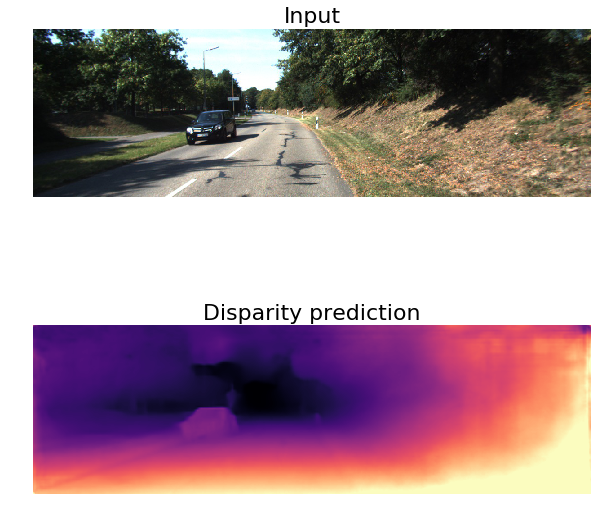

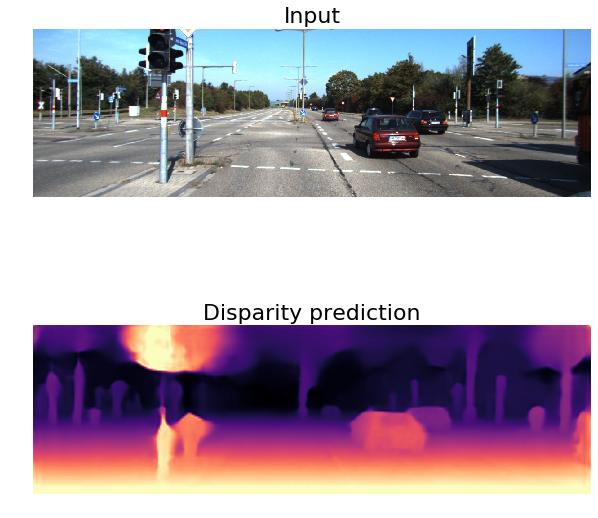

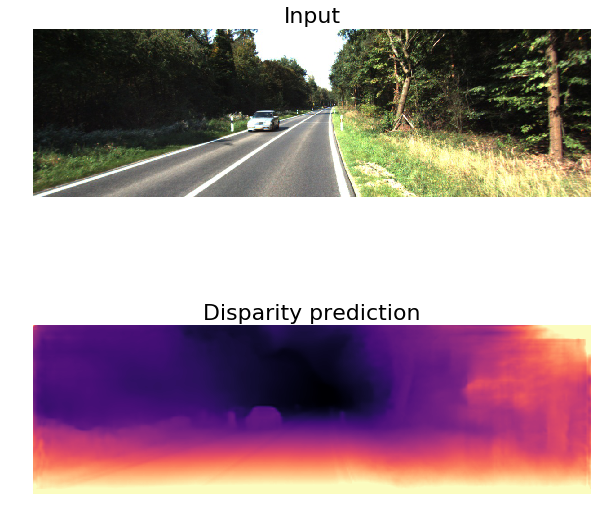

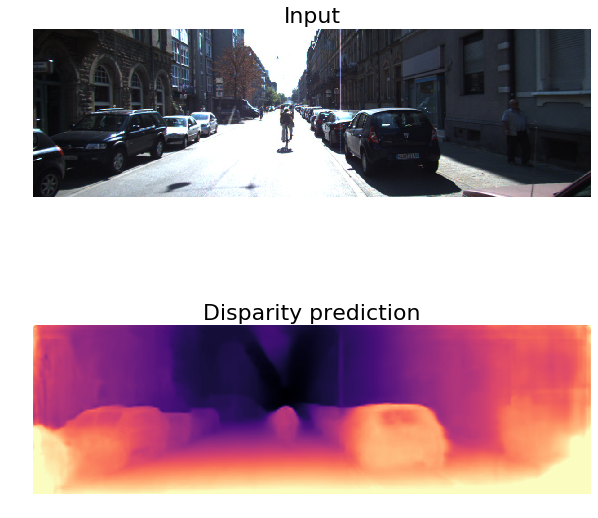

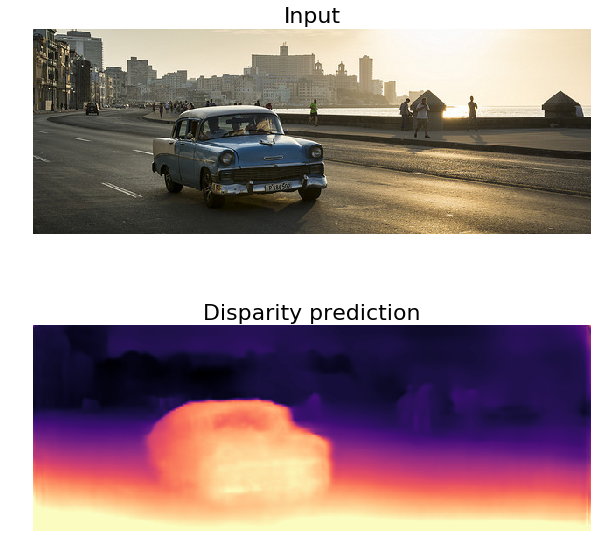

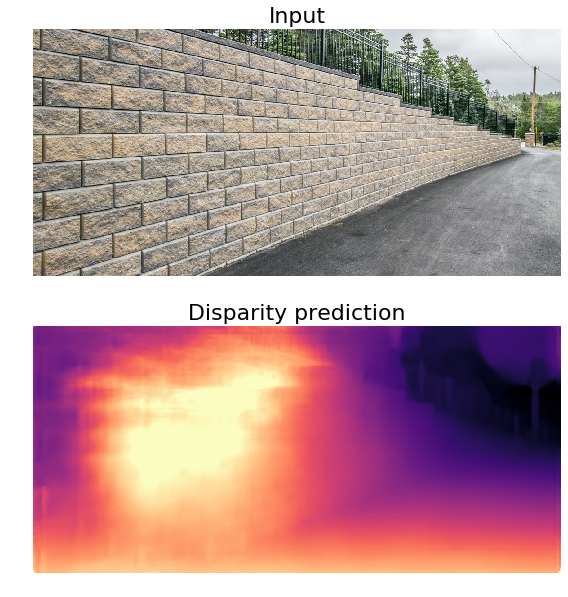

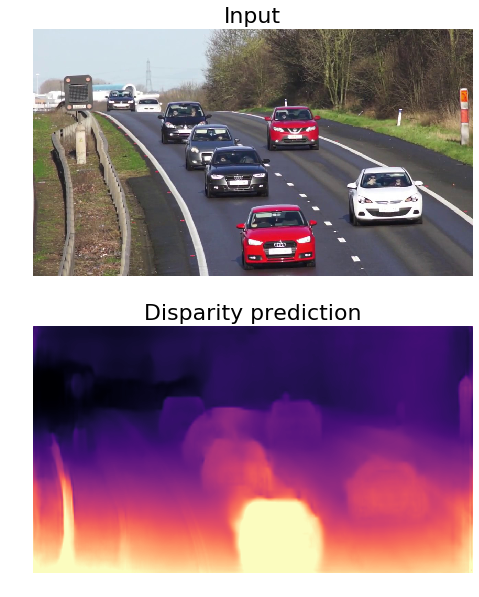

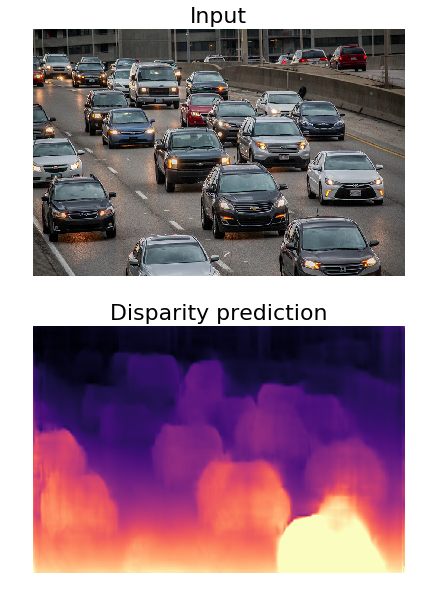

In [0]:
for i in range(1, 9):
        image_name = 'Test'+str(i)+'.jpg'
        image_path = '/home/ubuntu/monodepth2/assets/'+image_name
        input_image = pil.open(image_path).convert('RGB')
        original_width, original_height = input_image.size
        input_image_resized = input_image.resize((width, height), pil.LANCZOS)
        input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

        with torch.no_grad():
            #encoder.eval()
            #decoder.eval()
            model.eval()
            #features = encoder(input_image_pytorch.to(device))
            outputs = model(input_image_pytorch.to(device))

        disp = outputs
        disp_resized = torch.nn.functional.interpolate(disp,(original_height, original_width), mode="bilinear", align_corners=True)

        # Saving colormapped depth image
        disp_resized_np = disp_resized.squeeze().cpu().numpy()
        vmax = np.percentile(disp_resized_np, 95)

        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.imshow(input_image)
        plt.title("Input", fontsize=22)
        plt.axis('off')

        plt.subplot(212)
        plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
        plt.title("Disparity prediction", fontsize=22)
        plt.axis('off')
#         plt.savefig('disp_5_'+ image_name,dpi = 100)
    #saveModel(epoch_num)

In [0]:
disp.cpu()

In [0]:
import os

# test_path = "/home/ubuntu/monodepth2/kitti_data"

ftest = "/home/ubuntu/monodepth2/assets/videoimage/image_filename.txt"
test_filenames = open(ftest).readlines()


for f in test_filenames:
    print(f)
    input_image = pil.open('/home/ubuntu/monodepth2/assets/videoimage/'+f.strip()).convert('RGB')
    original_width, original_height = input_image.size
    input_image_resized = input_image.resize((width, height), pil.LANCZOS)
    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    
    with torch.no_grad():
        model.eval()
        outputs = model(input_image_pytorch.to(device))
#     print(outputs)
    disp = outputs
    disp_resized = torch.nn.functional.interpolate(disp,(original_height, original_width), mode="bilinear", align_corners=True)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    vmax = np.percentile(disp_resized_np, 95)

    plt.figure(figsize=(10, 10))
    plt.subplot(211)
    plt.imshow(input_image)
    plt.title("Input", fontsize=22)
    plt.axis('off')

    plt.subplot(212)
    plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
    plt.title("Disparity prediction", fontsize=22)
    plt.axis('off')

    
    plt.savefig('depthimages/'+f.strip(),dpi = 100)
    
    plt.close('all')
#     break
#     del outputs,features

1.jpg



/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


2.jpg

3.jpg

4.jpg

5.jpg

6.jpg

7.jpg

8.jpg

9.jpg

10.jpg

11.jpg

12.jpg

13.jpg

14.jpg

15.jpg

16.jpg

17.jpg

18.jpg

19.jpg

20.jpg

21.jpg

22.jpg

23.jpg

24.jpg

25.jpg

26.jpg

27.jpg

28.jpg

29.jpg

30.jpg

31.jpg

32.jpg

33.jpg

34.jpg

35.jpg

36.jpg

37.jpg

38.jpg

39.jpg

40.jpg

41.jpg

42.jpg

43.jpg

44.jpg

45.jpg

46.jpg

47.jpg

48.jpg

49.jpg

50.jpg

51.jpg

52.jpg

53.jpg

54.jpg

55.jpg

56.jpg

57.jpg

58.jpg

59.jpg

60.jpg

61.jpg

62.jpg

63.jpg

64.jpg

65.jpg

66.jpg

67.jpg

68.jpg

69.jpg

70.jpg

71.jpg

72.jpg

73.jpg

74.jpg

75.jpg

76.jpg

77.jpg

78.jpg

79.jpg

80.jpg

81.jpg

82.jpg

83.jpg

84.jpg

85.jpg

86.jpg

87.jpg

88.jpg

89.jpg

90.jpg

91.jpg

92.jpg

93.jpg

94.jpg

95.jpg

96.jpg

97.jpg

98.jpg

99.jpg

100.jpg

101.jpg

102.jpg

103.jpg

104.jpg

105.jpg

106.jpg

107.jpg

108.jpg

109.jpg

110.jpg

111.jpg

112.jpg

113.jpg

114.jpg

115.jpg

116.jpg

117.jpg

118.jpg

119.jpg

120.jpg

121.jpg

122.jpg

123.jpg

124.jpg


In [0]:
def run_images(epoch_num):
    directory = 'Iteration '+ str(epoch_num)+'/'
    parent_dir = 'StereoOutput/Resnet18/'+folder_name+'/'
    path = os.path.join(parent_dir, directory) 
    os.mkdir(path) 
    image_output_path = parent_dir+directory
    for i in range(1, 9):
        image_name = 'Test'+str(i)+'.jpg'
        image_path = '/home/ubuntu/monodepth2/assets/'+image_name
        input_image = pil.open(image_path).convert('RGB')
        original_width, original_height = input_image.size
        input_image_resized = input_image.resize((width, height), pil.LANCZOS)
        input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

        with torch.no_grad():
            encoder.eval()
            decoder.eval()
            features = encoder(input_image_pytorch.to(device))
            outputs = decoder(features)

        disp = outputs[("disp", 0)]
        disp_resized = torch.nn.functional.interpolate(disp,(original_height, original_width), mode="bilinear", align_corners=True)

        # Saving colormapped depth image
        disp_resized_np = disp_resized.squeeze().cpu().numpy()
        vmax = np.percentile(disp_resized_np, 95)

        plt.figure(figsize=(10, 10))
        plt.subplot(211)
        plt.imshow(input_image)
        plt.title("Input", fontsize=22)
        plt.axis('off')

        plt.subplot(212)
        plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
        plt.title("Disparity prediction", fontsize=22)
        plt.axis('off')
        plt.savefig(image_output_path+image_name,dpi = 100)
    saveModel(epoch_num)

In [0]:
#image_path = "/home/ubuntu/monodepth2/assets/Test8.jpg"
image_path = "/home/ubuntu/monodepth2/assets/Test1.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size
input_image_resized = input_image.resize((width, height), pil.LANCZOS)
input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

In [0]:
with torch.no_grad():
    #encoder.eval()
    #decoder.eval()
    model.eval()
    #features = encoder(input_image_pytorch.to(device))
    outputs = model(input_image_pytorch.to(device))#model(input_image_pytorch.to(device))

disp = outputs.cpu()

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


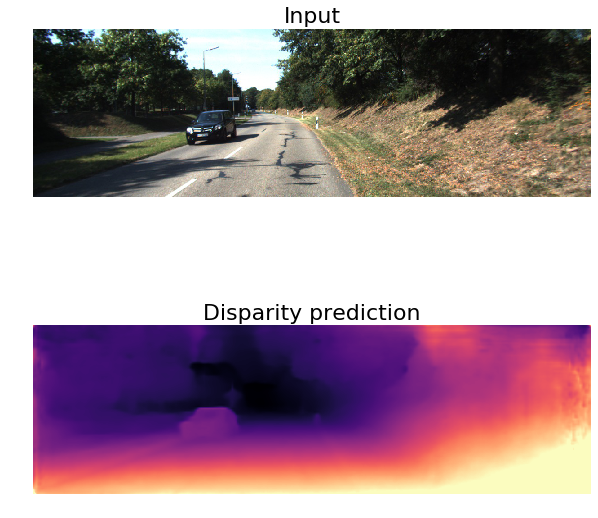

In [0]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=True)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')



plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');
#plt.savefig('Alpha/'+'0.95'+'.png',dpi = 100)